In [1]:
import pandas as pd 
import requests
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import pylab
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pylab.rcParams['figure.figsize'] = (14,10)
%matplotlib inline
import plotly.express as px
from plotly.io import write_html
from datetime import datetime


In [2]:
url = "https://min-api.cryptocompare.com/data/v2/histoday"


In [3]:
key = os.getenv("cryptocompare_key")

In [4]:
payload = {
    "api_key": key,
    "fsym": "BTC",
    "tsym": "USD",
    "limit": 730
}

In [5]:
result = requests.get(url, params = payload).json()

In [6]:
coin_df = pd.DataFrame(result['Data']['Data'])

In [7]:
coin_df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1516147200,11736.30,9205.38,11282.49,348631.94,3.666978e+09,11162.70,direct,
1,1516233600,12018.43,10642.33,11162.70,204918.02,2.357252e+09,11175.52,direct,
2,1516320000,11780.49,10867.18,11175.52,110885.87,1.264876e+09,11521.76,direct,
3,1516406400,13031.04,11502.11,11521.82,119084.84,1.492722e+09,12783.94,direct,
4,1516492800,12787.35,11101.73,12783.54,130427.64,1.552755e+09,11549.93,direct,
...,...,...,...,...,...,...,...,...,...
726,1578873600,8200.40,8057.37,8181.49,22746.00,1.844375e+08,8106.56,direct,
727,1578960000,8874.07,8106.40,8106.56,89444.78,7.680985e+08,8820.95,direct,
728,1579046400,8890.04,8559.93,8820.95,50394.79,4.411869e+08,8813.21,direct,
729,1579132800,8846.78,8586.56,8813.21,33539.82,2.909897e+08,8719.63,direct,


In [8]:
coin_df['time'] = pd.to_datetime(coin_df['time'], unit = 's')

In [9]:
coin_df = coin_df.rename(columns = {'time': 'Date'}).set_index('Date')

In [10]:
close_df = pd.DataFrame(coin_df['close'])

In [11]:
close_df.head()

,close
Date,
2018-01-17,11162.70
2018-01-18,11175.52
2018-01-19,11521.76
2018-01-20,12783.94
2018-01-21,11549.93


In [12]:
stationary_test = adfuller(close_df['close'])
print(stationary_test[1])

0.0887606672677263


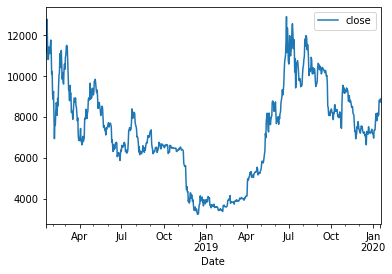

In [13]:
close_df.plot()
plt.show()

In [14]:
transform_data, lmda = boxcox(close_df)

In [15]:
print(lmda)

[0.86069522]


In [16]:
transformed_df = close_df.copy()

In [17]:
transformed_data = transform_data.flatten().tolist()

In [18]:
transformed_df['close'] = transformed_data

In [19]:
transformed_df.head()

,close
Date,
2018-01-17,3539.188737
2018-01-18,3542.688025
2018-01-19,3636.986978
2018-01-20,3977.502667
2018-01-21,3644.641604


In [20]:
transformed_df.tail()

,close
Date,
2020-01-13,2687.075438
2020-01-14,2889.763207
2020-01-15,2887.579782
2020-01-16,2861.159990
2020-01-17,2905.955680


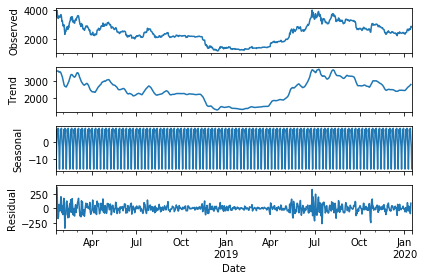

In [38]:
seasonal_decompose(transformed_df).plot()
plt.show()

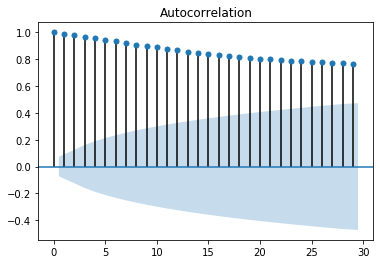

In [39]:
plot_acf(transformed_df)
plt.show()

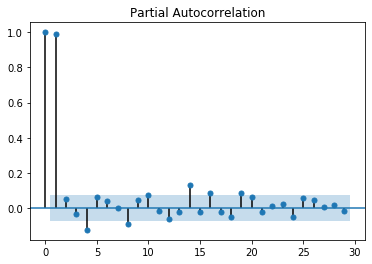

In [40]:
plot_pacf(transformed_df)
plt.show()

In [21]:
model = SARIMAX(transformed_df, order = (1,0,1))


C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [22]:
model_fit = model.fit(disp = True)

In [23]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  close   No. Observations:                  731
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4338.603
Date:                Fri, 17 Jan 2020   AIC                           8683.206
Time:                        11:35:34   BIC                           8696.989
Sample:                    01-17-2018   HQIC                          8688.523
                         - 01-17-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.001   1022.034      0.000       0.998       1.002
ma.L1         -0.0582      0.022     -2.594      0.009      -0.102      -0.014
sigma2      8290.0061    257.616     32.180      0.000    7785.088    8794.924
===================================================================================
Ljung-Box (Q):                       45.63   Jarque-Bera (JB):               456.07
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.28
Prob(H) (two-sided):                  0.87   Kurtosis:                         6.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

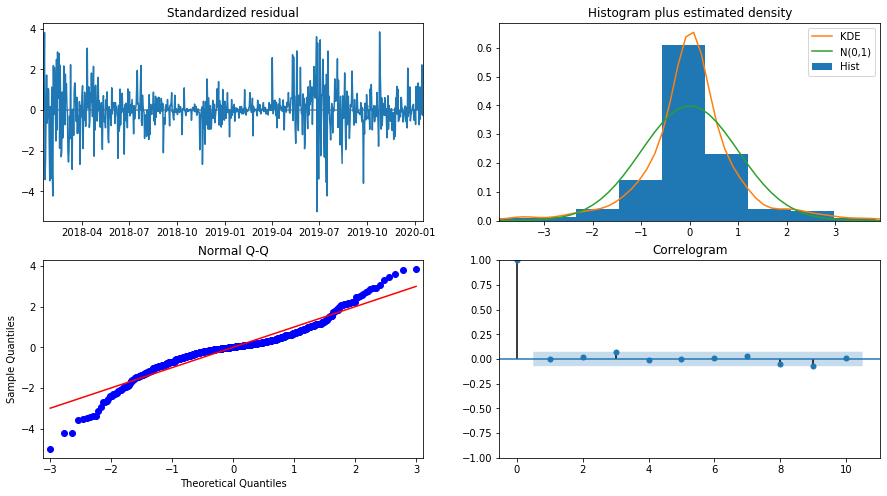

In [66]:
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [24]:
conf_int = model_fit.get_forecast(5)

In [25]:
confidence_intervals = conf_int.conf_int()

In [26]:
confidence_intervals = inv_boxcox(confidence_intervals, lmda)

In [27]:
confidence_intervals

,lower close,upper close
2020-01-18,8235.372671,9501.421823
2020-01-19,7997.974186,9736.523973
2020-01-20,7812.497028,9919.712468
2020-01-21,7654.976095,10074.952430
2020-01-22,7515.649106,10212.006163


In [28]:
predictions = model_fit.predict(start= 731, end = 735 )

In [29]:
predictions

2020-01-18    2902.254047
2020-01-19    2901.142089
2020-01-20    2900.030557
2020-01-21    2898.919451
2020-01-22    2897.808770
Freq: D, dtype: float64

In [30]:
predicted_close = inv_boxcox(predictions, lmda)

In [31]:
predicted_close

2020-01-18    8865.246805
2020-01-19    8861.302168
2020-01-20    8857.359286
2020-01-21    8853.418159
2020-01-22    8849.478787
Freq: D, dtype: float64

In [48]:
final_df = confidence_intervals.copy()

In [49]:
final_df['Predicted Price'] = predicted_close

In [50]:
final_df = final_df.round(2)

In [51]:
final_df = final_df.reset_index()

In [52]:
final_df

,index,lower close,upper close,Predicted Price
0,2020-01-18,8235.37,9501.42,8865.25
1,2020-01-19,7997.97,9736.52,8861.30
2,2020-01-20,7812.50,9919.71,8857.36
3,2020-01-21,7654.98,10074.95,8853.42
4,2020-01-22,7515.65,10212.01,8849.48


In [53]:
final_df = final_df.rename(columns = {'index': 'Date'})

In [54]:
final_df

,Date,lower close,upper close,Predicted Price
0,2020-01-18,8235.37,9501.42,8865.25
1,2020-01-19,7997.97,9736.52,8861.30
2,2020-01-20,7812.50,9919.71,8857.36
3,2020-01-21,7654.98,10074.95,8853.42
4,2020-01-22,7515.65,10212.01,8849.48


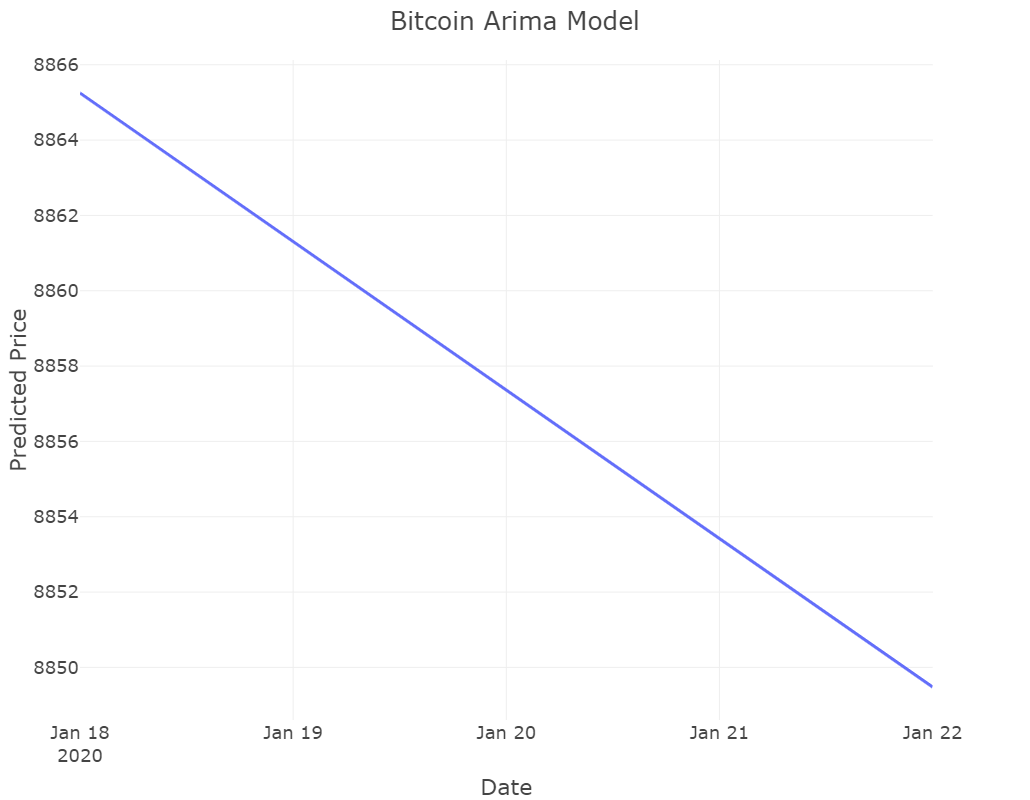

In [72]:
fig = px.line(final_df, x ='Date', y = 'Predicted Price')

fig.update_xaxes(nticks = 5)
fig.update_yaxes(automargin=True)
fig.update_layout(title_text = 'Bitcoin Arima Model', autosize = True, height = 800, width = 950, template = 'presentation')